In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

In [4]:
# Get Mnist data and split into train validation and test
def get_mnist():

    data=np.float64(np.load('MNIST.npy'))
    labels=np.float32(np.load('MNIST_labels.npy'))
    #print(data.shape)
    
    data=np.float32(data)/255.
    
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [5]:
# Get CIFAR10 data and split into train validation and test
def get_cifar():
    tr=np.float32(np.load('CIFAR_10.npy'))
    tr_lb=np.int32(np.load('CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [6]:
# Get transformed Mnist data
def get_mnist_trans():
    test_trans_dat=np.float32(np.load('MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

In [7]:
# Convolution layer with relu 
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    #[Filter size, color, Number of filter]
    
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    
    #padding same : same image size after convolution
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME') 
    #(N, 28,28, 32)
    relu = tf.nn.relu(conv + b)
    return(relu)

In [8]:
# Fully connected layer
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [9]:
# The network

#tf.reset_default_graph()

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1] #After pooling, size -> 1/2
    # The network:
    with tf.variable_scope("conv1"):
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv3"):
            relu3 = conv_relu_layer(pool2, filter_size=[5, 5],num_features=64)
            pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=[1,1,1,1], padding='SAME')
            
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool3,keep_prob)
            
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r = tf.nn.relu(fc1)
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [10]:
# Get loss and accuracy on a data set with output from final layer fc2.

# Function to get loss and accuracy from only one run of the feature extraction network
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    #print('Get stats time:',round(time.time()-t1,2),'(s)')
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

In [11]:
# Run one epoch
# Run the iterations of one epoch

def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            #if (np.mod(j,5000)==0):
            #    print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        #print('Epoch time    :',round(time.time()-t1,2),'(s)')

In [12]:
#Get the corresponding data

def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

## Load the data

In [14]:
train, val, test = get_cifar()

## Display some of the images 

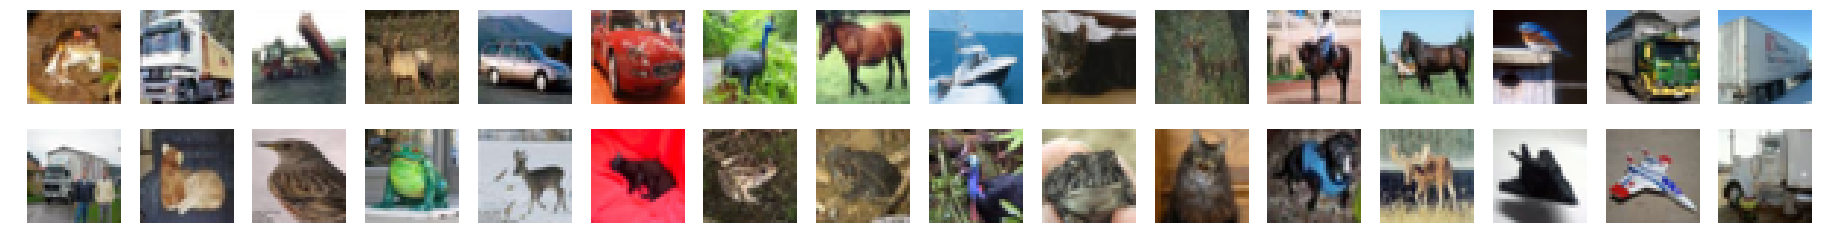

In [15]:
#Display first 32 pictures in training data
nrows = 2; ncols=16;
plt.figure(figsize = (ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(train[0][i,:].reshape(32,32,3), cmap='gray')
    plt.axis('off')
plt.show()

### Modified and run the code to apply the original network to the cifar data 

In [17]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=5
num_train=45000
minimizer="Adam"
model_name="model_cifar"
keep_prob=.5

data_set="cifar"; dim=32; nchannels=3

TrainLoss=[]
TrainAccu=[]
ValLoss=[]
ValAccu=[]

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels]) 
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y") 

lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
    train,val,test=get_data(data_set=data_set)
    
    # Create the network architecture with the above placeholdes as the inputs.
    cross_entropy, accuracy, fc2 =create_network()

    # Define the miminization method
    if (minimizer=="Adam"):
        train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
    elif (minimizer=="SGD"):
        train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Show trainable variables
    for v in tf.trainable_variables():
        print(v.name,v.get_shape().as_list(),np.std(v.eval()))
    ii=np.arange(0,num_train,1)
    print("-------------------------------------------------------")
    
    # Run epochs
    for i in range(num_epochs):  # number of epochs
        run_epoch(train,val,ii,batch_size,train_step)
        #if (np.mod(i,2)==0):
        lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
        TrainLoss.append(lo)
        print('Epoch:',i,', Train loss     :',round(lo,4), ', Accuracy:',round(ac,4))
        vlo,vac = get_stats(val[0],val[1])
        ValLoss.append(vlo)
        print('Epoch:',i,', Validation loss:',round(vlo,4),', Accuracy:',round(vac,4))
            
    # Test set accuracy
    print("-------------------------------------------------------")
    print('Test accuracy : %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
    
    # Save model
    tf.add_to_collection("optimizer", train_step)
    saver = tf.train.Saver()
    save_path = saver.save(sess, "tmp/"+model_name)
    print("Model saved in path: %s" % save_path)

conv1/W:0 [5, 5, 3, 32] 0.04732075
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028838381
conv2/b:0 [64] 0.0
conv3/W:0 [5, 5, 64, 64] 0.025000403
conv3/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.021438278
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08683187
fc2/b:0 [10] 0.0
-------------------------------------------------------
Epoch: 0 , Train loss     : 1.5229 , Accuracy: 0.4478
Epoch: 0 , Validation loss: 1.515 , Accuracy: 0.4452
Epoch: 1 , Train loss     : 1.3328 , Accuracy: 0.5209
Epoch: 1 , Validation loss: 1.3476 , Accuracy: 0.5166
Epoch: 2 , Train loss     : 1.1318 , Accuracy: 0.6
Epoch: 2 , Validation loss: 1.147 , Accuracy: 0.59
Epoch: 3 , Train loss     : 1.0157 , Accuracy: 0.6383
Epoch: 3 , Validation loss: 1.0434 , Accuracy: 0.6294
Epoch: 4 , Train loss     : 0.9667 , Accuracy: 0.6566
Epoch: 4 , Validation loss: 1.0291 , Accuracy: 0.6398
-------------------------------------------------------
Test accuracy : 0.628
Model saved in path: tmp/model_cifar


### Plot training and validation error against epoch number 

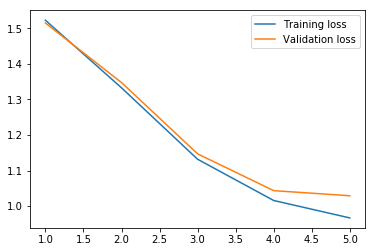

In [18]:
Epoch=range(1,num_epochs+1)
plt.plot(Epoch,TrainLoss)
plt.plot(Epoch,ValLoss)
plt.legend(['Training loss','Validation loss'], loc='upper right')

Compared with MNIST dataset, the network with CIFAR10 shows worse performance.

### Plot the first layer filter

In [19]:
with tf.Session() as sess:
    # Get data
    train, val, test=get_data(data_set=data_set)
    # Load model info
    saver = tf.train.import_meta_graph('tmp/'+model_name+'.meta')
    saver.restore(sess,'tmp/'+model_name) 
    graph = tf.get_default_graph()
    # Setup the placeholders from the stored model.
    x = graph.get_tensor_by_name('x:0')
    y_= graph.get_tensor_by_name('y:0')
    lr_ = graph.get_tensor_by_name('learning_rate:0')
    keep_prob_ = graph.get_tensor_by_name('keep_prob:0')
    accuracy=graph.get_tensor_by_name('helpers/ACC:0')
    cross_entropy=graph.get_tensor_by_name('cross_entropy_loss/LOSS:0')
    fc2=graph.get_tensor_by_name('OUT:0')
    
    ConV1Weight=graph.get_collection('trainable_variables')[0].eval()

INFO:tensorflow:Restoring parameters from tmp/model_cifar


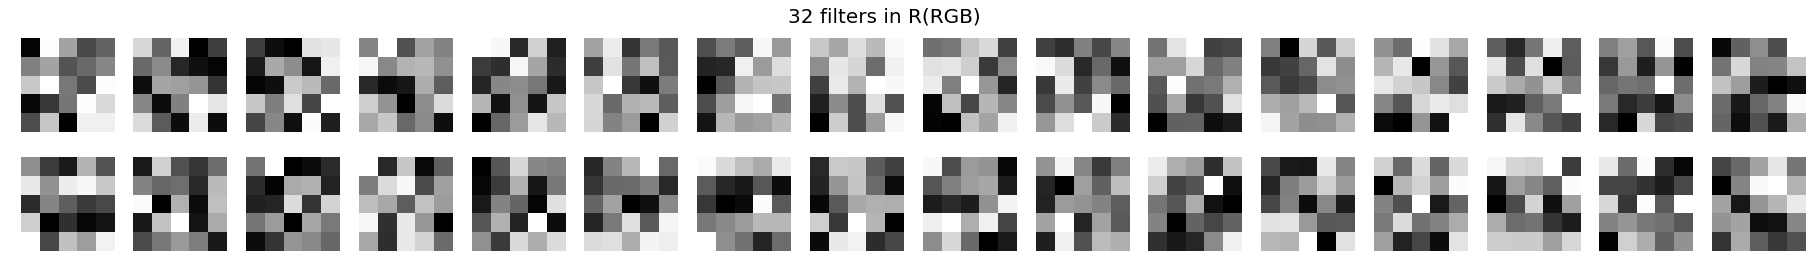

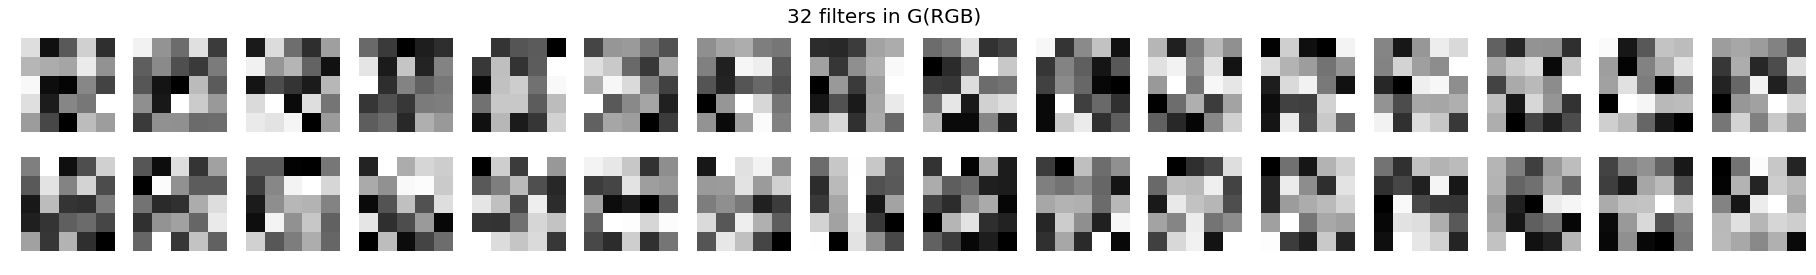

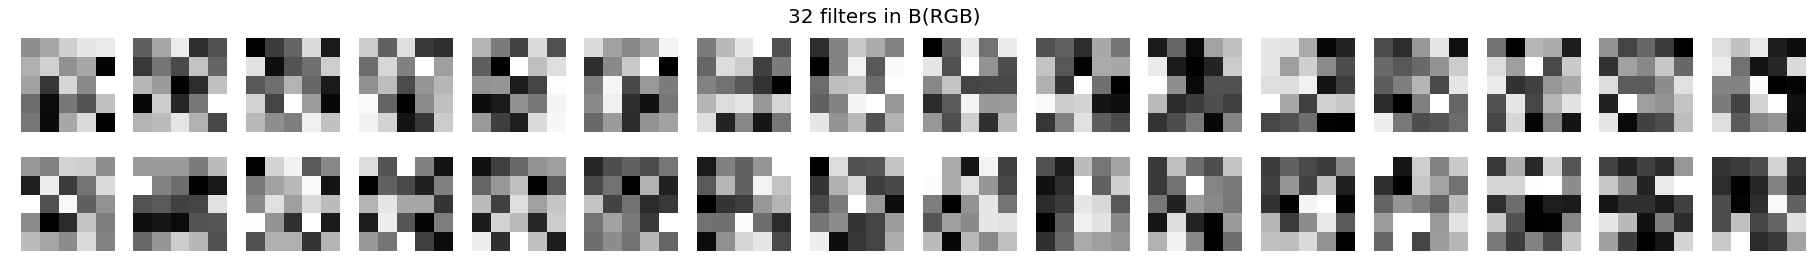

In [22]:
nrows = 2; ncols=16; 
plt.figure(figsize = (ncols*2, nrows*2))
plt.suptitle('32 filters in R(RGB)',fontsize=20)
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(ConV1Weight[:,:,0,i].reshape(5,5), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize = (ncols*2, nrows*2))
plt.suptitle('32 filters in G(RGB)',fontsize=20)
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(ConV1Weight[:,:,1,i].reshape(5,5), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize = (ncols*2, nrows*2))
plt.suptitle('32 filters in B(RGB)',fontsize=20)
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(ConV1Weight[:,:,2,i].reshape(5,5), cmap='gray')
    plt.axis('off')
plt.show()

### Transform RGB to HSV and convert back with some variability

In [20]:
from skimage import color

In [21]:
#RGB to HSV

HSVtrain=np.zeros((45000,32,32,3))
for i in range(45000):
    HSVtrain[i] = color.rgb2hsv(train[0][i,:].reshape(32,32,3)) 
    fv = float(np.random.uniform(.75,1.25, 1))
    HSVtrain[i,:,1,:] = HSVtrain[i,:,1,:] * fv
    
#HSV to RGB

RGBtrain = np.zeros((45000,32,32,3)) 
for i in range(45000):
    RGBtrain[i,:,:,:] = color.hsv2rgb(HSVtrain[i,:,:,:])
RGBtrain = RGBtrain.reshape(45000,32*32*3)

In [23]:
min(RGBtrain[0,:])

-0.07771572156580046

As we can see, there is a negative value in the RGB. However, in python, floating point image RGB values must be in the 0..1 range. Therefore, I convert such value with zero. If the value is larger than 1, convert the value with one.

In [24]:
#Convert such outlier data
for i in range(45000):
    for j in range(32*32*3):
        if(RGBtrain[i,j]<0):
            RGBtrain[i,j]=0
        elif(RGBtrain[i,j]>1):
            RGBtrain[i,j]=1

### Display some of the resulting image 

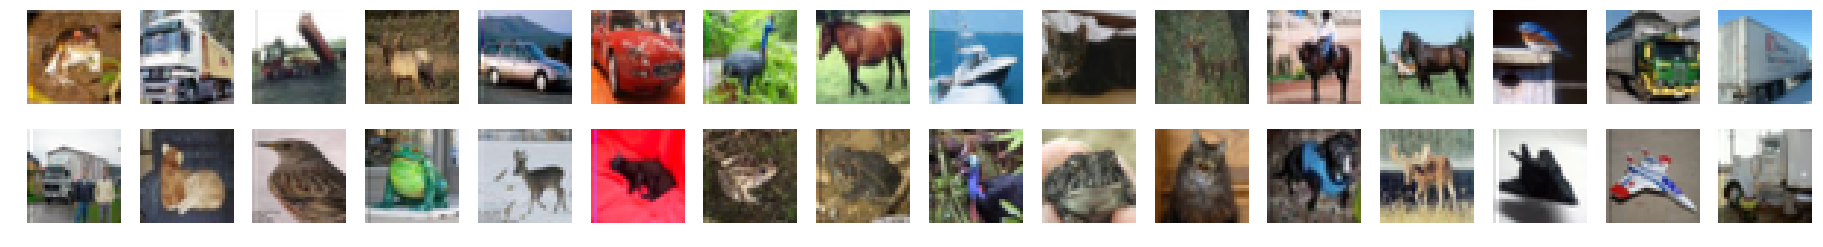

In [25]:
nrows = 2; ncols=16;
plt.figure(figsize = (ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(RGBtrain[i,:].reshape(32,32,3), cmap='gray')
    plt.axis('off')
plt.show()

I display the same images above. The images are very closed to original images. It is hard to figure out the difference between both image set.

### Run the model with the modified data and report the result

In [26]:
import time
batch_size=500
step_size=.001
num_epochs=5
num_train=45000 
minimizer="Adam"
model_name="model_cifar"
keep_prob=.5

data_set="cifar"; dim=32; nchannels=3 #Changed

TrainLoss_m=[]
ValLoss_m=[]

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
    #train,val,test=get_data(data_set=data_set)
    train = tuple((RGBtrain, train[1]))
    
    # Create the network architecture with the above placeholdes as the inputs.
    cross_entropy, accuracy, fc2 =create_network()

    # Define the miminization method
    if (minimizer=="Adam"):
        train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
    elif (minimizer=="SGD"):
        train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Show trainable variables
    for v in tf.trainable_variables():
        print(v.name,v.get_shape().as_list(),np.std(v.eval()))
    ii=np.arange(0,num_train,1)
    print("-------------------------------------------------------")
    
    # Run epochs
    for i in range(num_epochs):  # number of epochs
        run_epoch(train,val,ii,batch_size,train_step)
        #if (np.mod(i,2)==0):
        lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
        TrainLoss_m.append(lo)
        print('Epoch:',i,', Train loss     :',round(lo,4), ', Accuracy:',round(ac,4))
        vlo,vac = get_stats(val[0],val[1])
        ValLoss_m.append(vlo)
        print('Epoch:',i,', Validation loss:',round(vlo,4),', Accuracy:',round(vac,4))
            
    # Test set accuracy
    print("-------------------------------------------------------")
    print('Test accuracy : %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

conv1/W:0 [5, 5, 3, 32] 0.04741889
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.0288949
conv2/b:0 [64] 0.0
conv3/W:0 [5, 5, 64, 64] 0.025014367
conv3/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.021442043
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08649806
fc2/b:0 [10] 0.0
-------------------------------------------------------
Epoch: 0 , Train loss     : 1.4901 , Accuracy: 0.4557
Epoch: 0 , Validation loss: 1.4975 , Accuracy: 0.4528
Epoch: 1 , Train loss     : 1.2387 , Accuracy: 0.5517
Epoch: 1 , Validation loss: 1.2435 , Accuracy: 0.5554
Epoch: 2 , Train loss     : 1.0615 , Accuracy: 0.6221
Epoch: 2 , Validation loss: 1.0936 , Accuracy: 0.6106
Epoch: 3 , Train loss     : 0.928 , Accuracy: 0.6773
Epoch: 3 , Validation loss: 0.9788 , Accuracy: 0.6588
Epoch: 4 , Train loss     : 0.8634 , Accuracy: 0.6989
Epoch: 4 , Validation loss: 0.9334 , Accuracy: 0.673
-------------------------------------------------------
Test accuracy : 0.665


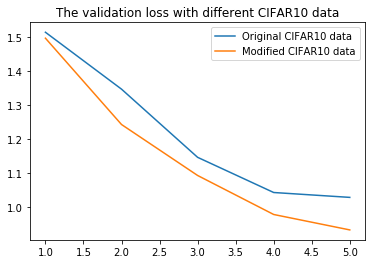

In [27]:
# Plot training and validation error against epoch number 
Epoch=range(1,num_epochs+1)
plt.plot(Epoch,ValLoss)
plt.plot(Epoch,ValLoss_m)
plt.title("The validation loss with different CIFAR10 data")
plt.legend(['Original CIFAR10 data','Modified CIFAR10 data'], loc='upper right')

When we train the model with the modified dataset, it shows slightly better performance. In my opnion, the reason is that the training data has some variability so it can explain test data better. If I can use more training data and more epoch time, the performance will be improved. Also, by changing the network structure, it is possible to improve the performance.